Theoretical orbit response to kick $\theta$:

$$C_{ij} = \theta_i \frac{ \sqrt{\beta_i \beta_j}}{2 \sin{\pi Q}} \cos(  2 \pi | \mu_i - \mu_j| - \pi Q) + \frac{\eta_i \eta_j}{\left( \alpha_C - \frac{1}{\gamma^2}\right) C}$$

LOCO needs to compute

$$M_x = \frac{\partial^2 x_i}{\partial \theta_j \partial k_{1,m}}$$
$$M_y = \frac{\partial^2 y_i}{\partial \theta_j \partial k_{1,m}}$$

where $\{\theta_j\}$ are orbit correctors hor. and vert.

and

$\{ k_{1,m}\}$ are quadrupole normal and skew used for correction, as many as there are power supplies

input:
perturb.param or script generating same
...

In [1]:
print(f"LOCO, AT version")
from at import *
from pylab import *
from AT_ORM import *
from at.load import load_mat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
from random import random

LOCO, AT version


In [2]:
# The lattice

from lattice2 import *
#ring = [B1H, CXY01, DD, BPM, QF,SF, DD, B1H, B1H, CXY02, DD, BPM, QD, DD, B1H, m0]
ring=at.Lattice(ring, energy=1)
ring.radiation_off()

preparing twiss ..
Tunes=[0.21808517 0.11816895]
Chrom=[ 1.94950847 -2.27073414]


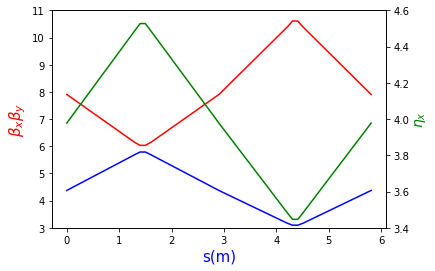

In [3]:
elements_indexes = get_refpts(ring, elements.Monitor)
twiss = getOptics(ring, '*', 'beta', 'False')

(2, 2)


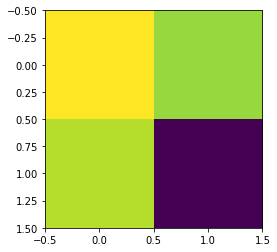

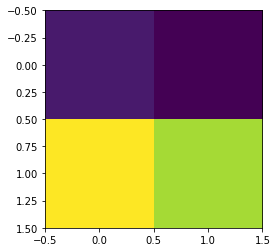

Cyy [[ 7.87246132 11.13094761]
 [10.92973559 13.55963438]]
Cyx [[0.11277884 0.10495551]
 [0.21452175 0.19964067]]


In [4]:
Cxx, Cxy= ORM_x(1.e-3, ring)
Cyy, Cyx= ORM_y(1.e-3, ring)

print(shape(Cxx))

plt.figure()
imshow(Cxx)
plt.show()

plt.figure()
imshow(Cyx)
plt.show()

print('Cyy',Cyy)
print('Cyx',Cyx)

In [5]:
quads_info = quad_info(ring)

Done...


In [6]:
quad_dict,quad_vals = getQuadFamilies(quads_info)
quads = [ k for k in quad_dict.keys()]
print(f"Quadrupoles:{quads}")
iq = 1
print(quads[iq], quad_dict[quads[iq]])
print(quad_vals[quads[iq],0])
print(quad_vals[quads[iq],0])
eocc_a, vals = getQuadFamilies(quads_info)
print(eocc_a)
print(quad_vals[quads[iq],0])

Quadrupoles:['QF', 'QD']
QD 0
-2.1
-2.1
{'QF': 0, 'QD': 0}
-2.1


In [9]:
def computeOpticsD(ring, qname, i, dk):

    bpm_indexes = get_refpts(ring, elements.Monitor)
    quad_indexes = get_refpts(ring, qname)

    #print(ring[quad_indexes[i]].K)
    ring[quad_indexes[i]].K =  quad_vals[qname,i] + dk

    qxx, qxy= ORM_x(0.0001, ring)
    qyy, qyx= ORM_y(0.0001, ring)

    ring[quad_indexes[i]].K = quad_vals[qname,i]
    print(ring[quad_indexes[i]].K)
    #print('Done')

    return  qxx, qxy, qyy, qyx

In [10]:
%%time
# sequential version, this takes long:
# optimize with parallelization and separate function
# prepare

dk = 0.0001
qxx = []
qxy =[]
qyy = []
qyx =[]
quad_names = quads
for qname in quad_names:
    print('generating response to {}, n={}'.format(qname, quad_dict[qname]))
    nq = quad_dict[qname]+1
    for i in range(0,nq):
       Qxx, Qxy, Qyy, Qyx = computeOpticsD(ring, qname,i, dk)
       qxx.append(Qxx)
       qxy.append(Qxy)
       qyy.append(Qyy)
       qyx.append(Qyx)

generating response to QF, n=0
1.7
generating response to QD, n=0
-2.1
Wall time: 28.9 ms


In [11]:
from loco import getTheorOrm, getOrm
from pylab import *

C0x = Cxx
C0y = Cyy
C0xy = Cxy
C0yx = Cyx

dk = 0.0001
dCx = []
dCy = []
dCxy = []
dCyx = []
quad_names = quads
for qname in quad_names:
    nquad = quad_dict[qname]
    print('loading response to:',qname)
    for i in range(0,nquad+1):

        C1x = qxx[i]
        C1y = qyy[i]
        C1xy = qxy[i]
        C1yx = qyx[i]

        dCx.append( (C1x-C0x)  / dk)
        dCy.append( (C1y-C0y) /dk)
        dCxy.append( (C1xy-C0xy)/ dk)
        dCyx.append( (C1yx-C0yx)/ dk)

loading response to: QF
loading response to: QD


In [12]:
len(dCx)
dCx[0]

array([[206.52180982, 192.18646874],
       [180.70039229, 168.15681266]])

In [12]:
## simulate_errors

In [13]:
errorQF = 72.e-3 #0.01
errorQD = 52.e-3 #0.01
#tiltQF = 0.0003
#tiltQD = 0.0003

quads_info_error = simulateError(ring,errorQF,errorQD)

simulating perturbed machine...
Done...


preparing twiss ..
Tunes=[0.22108999 0.1155954 ]
Chrom=[ 1.89487948 -2.2582334 ]


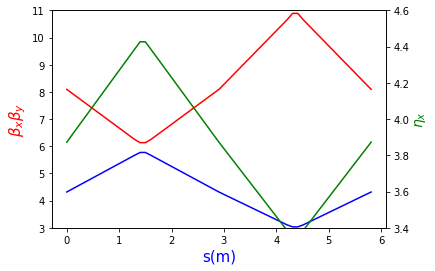

In [14]:
twiss_error = getOptics(ring, '*', 'beta', 'True')

In [15]:
#Cell2

(2, 2)


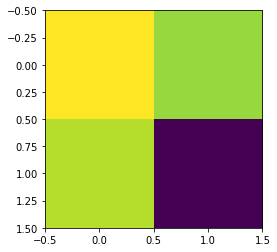

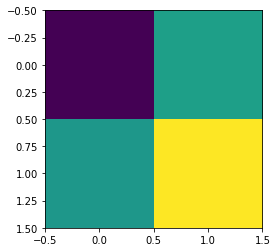

In [18]:
# ORM Cx, Cy

Cxx_err, Cxy_err= ORM_x_error(1.e-3, ring)
Cyy_err, Cyx_err= ORM_y_error(1.e-3, ring)

print(shape(Cxx_err))

plt.figure()
imshow(Cxx)
plt.show()

plt.figure()
imshow(Cyy_err)
plt.show()

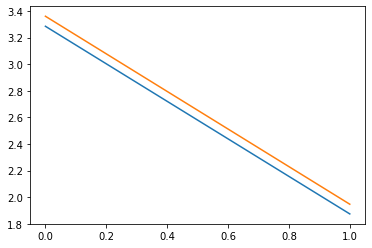

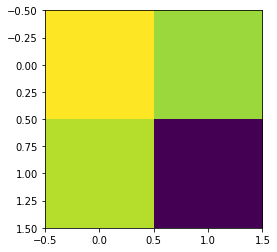

In [19]:
plt.plot(Cxx_err[1])
plt.plot((Cxx[1]))
plt.show()
plt.imshow(Cxx_err)
plt.show()

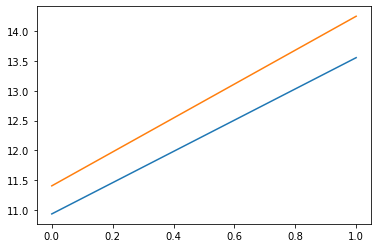

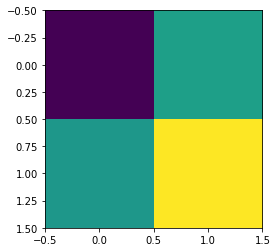

In [20]:
plt.plot(Cyy[1])
plt.plot((Cyy_err[1]))
plt.show()
plt.imshow(Cyy_err)

In [21]:
Cxx

array([[3.538856  , 3.29592079],
       [3.3608066 , 1.9463771 ]])

In [22]:
print(np.max(Cyy_err-Cyy))

0.6970765988820933


In [20]:
#Cell4

In [23]:
#A, B = build_matrix(ormx, ormy, C0x, C0x, C0x, dCx, dCy, dCxy, Cyx, ormx, ormy)


Nk = len(dCx) #number of free parameters (number of quads or g_k)
Nm = 40 # number of measurements (iteration) ######### #######
print('NK:', Nk)
print('Nm:', Nm)

Ax = np.zeros([Nk,Nk])
Ay = np.zeros([Nk,Nk])
Axy = np.zeros([Nk,Nk])
Ayx = np.zeros([Nk,Nk])

A = np.zeros([4*Nk,Nk]) # (160, 40) ###########


NK: 2
Nm: 40


In [24]:
Bx = np.zeros([Nk,1])
By = np.zeros([Nk,1])
Bxy = np.zeros([Nk,1])
Byx = np.zeros([Nk,1])

B = np.zeros([4*Nk,1])


In [25]:
Dx = (Cxx_err[0:Nm,:] - C0x[0:Nm,:]) ### dk ?
Dy = (Cyy_err[0:Nm,:] - C0y[0:Nm,:])
Dxy = (Cxy_err[0:Nm,:] - C0xy[0:Nm,:])
Dyx = (Cyx_err[0:Nm,:] - C0yx[0:Nm,:])

In [26]:
Dx.shape

(2, 2)

In [27]:
for i in range(Nk): ## i represents each quad
    #print('done A:', 100.* i ,'%')
    for j in range(Nk):
        Ax[i,j] = np.sum(np.dot(dCx[i],dCx[j].T) )
        Ay[i,j] = np.sum(np.dot(dCy[i],dCy[j].T) )
        Axy[i,j] = np.sum(np.dot(dCxy[i],dCxy[j].T) )
        Ayx[i,j] = np.sum(np.dot(dCyx[i],dCyx[j].T) )
    A[i,:] = Ax[i,:]
    A[i+Nk,:] = Ay[i,:]
    A[i+2*Nk,:] = Axy[i,:]
    A[i+3*Nk,:] = Ayx[i,:]

In [28]:
np.sum(np.dot(dCx[1],dCx[1].T))

279788.3142689824

In [29]:
B.shape

(8, 1)

In [30]:
for i in range(Nk):
    Bx[i] = np.sum( np.dot(dCx[i], Dx.T) )
    By[i] = np.sum( np.dot(dCy[i], Dy.T) )
    Bxy[i] = np.sum( np.dot(dCxy[i], Dxy.T) )
    Byx[i] = np.sum( np.dot(dCyx[i], Dyx.T) )
    B[i] = Bx[i]
    B[i+Nk] = By[i]
    B[i+2*Nk] = Bxy[i]
    B[i+3*Nk] = Byx[i]

number of singular values 2
A(8, 2) B(8, 1) U(8, 8) smat(8, 2) v(2, 2)


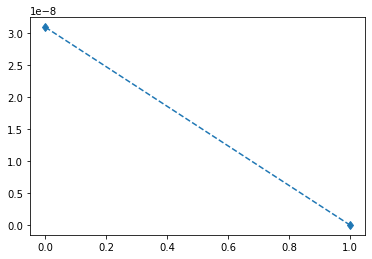

In [31]:
u,s,v=np.linalg.svd(A,  full_matrices=True)

smat = 0.0 * A
si = s**-1
n_sv = 1
si[n_sv:] *= 0.0

print("number of singular values {}".format(len(si)))
smat[:Nk,:Nk] = np.diag(si)


print('A'+str(A.shape), 'B'+str(B.shape),'U'+str(u.shape), 'smat'+str(smat.shape), 'v'+str(v.shape))


plt.plot(si,'d--')
plt.show()

In [28]:
si

array([1.54847103e-06, 0.00000000e+00])

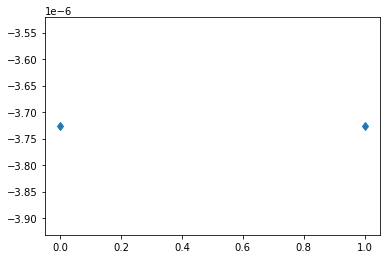

In [32]:
Ai=np.dot(v.transpose(),np.dot(smat.transpose(),u.transpose()))

###
r = ( np.dot(Ai,B)).reshape(-1)
plot(r,'d')
plt.show()

In [36]:
Ai.shape

(2, 8)

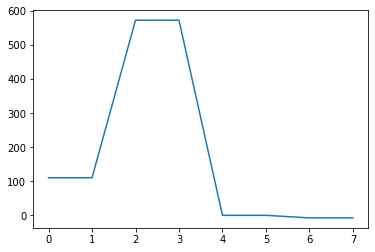

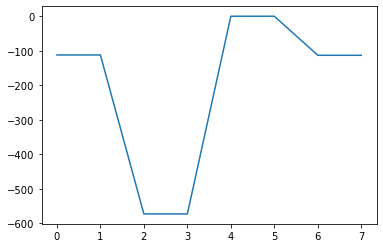

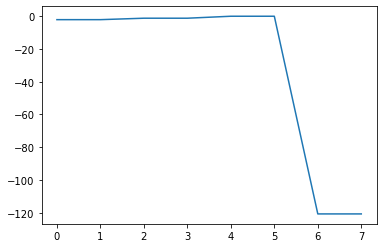

In [33]:
# error
e = np.dot(A,r).reshape(-1) - B.reshape(-1)
plt.plot(e)
plt.show()
plt.plot(B)
plt.show()
plt.plot(np.dot(A,r).reshape(-1))
plt.show()


In [34]:
np.dot(A,r).reshape(-1)

array([  -2.08520256,   -2.08520256,   -1.20278899,   -1.20278899,
          0.        ,    0.        , -120.73882443, -120.73882443])

In [31]:
B

array([[-67.15801248],
       [-67.15801248],
       [-47.51462107],
       [-47.51462107],
       [  0.        ],
       [  0.        ],
       [ -0.2184393 ],
       [ -0.2184393 ]])

In [35]:
quad_dict,quad_vals = getQuadFamilies(quads_info_error)
quads = [ k for k in quad_dict.keys()]
print(f"Quadrupoles:{quads}")
iq = 1
print(quads[iq], quad_dict[quads[iq]])
print(quad_vals[quads[iq],1])
print(quad_vals[quads[iq],1])
eocc_a, vals = getQuadFamilies(quads_info_error)
print(eocc_a)
print(quad_vals[quads[iq],1])

Quadrupoles:['QF', 'QD']
QD 1
-2.1094352785711874
-2.1094352785711874
{'QF': 1, 'QD': 1}
-2.1094352785711874


In [36]:
# check correction...


n_list = len(quads_info_error.s_pos)
print(n_list)

quad_names = quad_names
iq = 0
frac = 1.0
cor_dict = {}
for qname in quad_names:
    nquad = quad_dict[qname]
    #print(qname, quad_dict[qname])
    for i in range(0, nquad):
        cor_dict[qname, i+1] = -r[iq]*frac
        iq += 1

2


In [44]:
nquad

1

In [37]:
DK = []
for idx in range(n_list):
   qname_ = quads_info.elements_name[idx]  # ElementName

   if qname_ == 'QF':
      occ = quads_info_error.occ[idx]
      dk = cor_dict['QF',occ]
      DK.append(dk)

   if qname_ == 'QD':
      occ = quads_info_error.occ[idx]
      dk = cor_dict['QD',occ]
      DK.append(dk)

In [38]:
r

array([-3.72639323e-06, -3.72639323e-06])

In [36]:
DK

[9.047581175821778e-05, 9.047581175821775e-05]

In [39]:
QF_indexes = get_refpts(ring, 'QF')
QD_indexes = get_refpts(ring, 'QD')
quads_indexes = get_refpts(ring, elements.Quadrupole)

In [40]:

print(ring[quads_indexes[1]].K)
ring[quads_indexes[0]].K += DK[0]
ring[quads_indexes[1]].K += DK[1]
print(ring[quads_indexes[1]].K)



-2.1094352785711874
-2.109431552177962


In [41]:
quads_info_error.Quad_strength

0    1.770115
1   -2.109435
Name: Quad_strength, dtype: float64

preparing twiss ..
Tunes=[0.22109026 0.11559489]
Chrom=[ 1.89487322 -2.25823789]


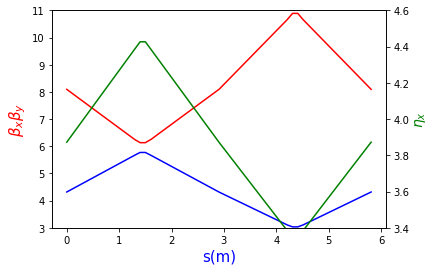

In [42]:
twiss_corrected = getOptics(ring, '*', 'beta', 'True')

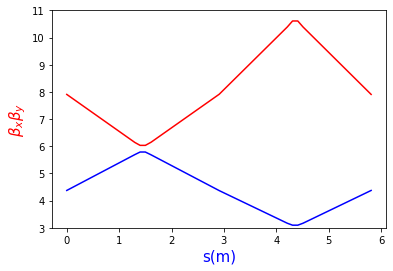

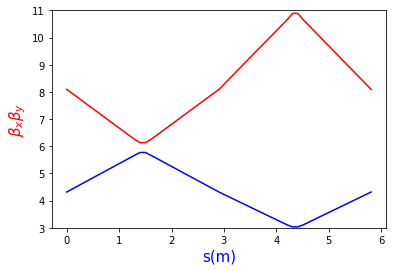

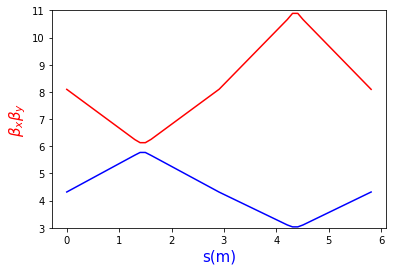

In [43]:

fig, ax = plt.subplots()
ax.plot(twiss.s_pos, twiss.betax, color="blue")
ax.plot(twiss.s_pos, twiss.betay, color="red")
ax.set_xlabel(r's(m)', color="blue", fontsize=15)
ax.set_ylabel(r'$\beta_x$', color="blue", fontsize=15)
ax.set_ylim([3, 11])
ax.set_ylabel(r'$\beta_x \beta_y$', color="red", fontsize=15)
plt.show()



fig, ax = plt.subplots()
ax.plot(twiss_error.s_pos, twiss_error.betax, color="blue")
ax.plot(twiss_error.s_pos, twiss_error.betay, color="red")
ax.set_xlabel(r's(m)', color="blue", fontsize=15)
ax.set_ylabel(r'$\beta_x$', color="blue", fontsize=15)
ax.set_ylim([3, 11])
ax.set_ylabel(r'$\beta_x \beta_y$', color="red", fontsize=15)
plt.show()


fig, ax = plt.subplots()
ax.plot(twiss_corrected.s_pos, twiss_corrected.betax, color="blue")
ax.plot(twiss_corrected.s_pos, twiss_corrected.betay, color="red")
ax.set_xlabel(r's(m)', color="blue", fontsize=15)
ax.set_ylabel(r'$\beta_x$', color="blue", fontsize=15)
ax.set_ylim([3, 11])
ax.set_ylabel(r'$\beta_x \beta_y$', color="red", fontsize=15)
plt.show()


In [44]:
twiss_error

,s_pos,closed_orbitx,closed_orbity,betax,betay,elements_strength,elements_name,occ,elements_type
0,0.00,0.0,0.0,4.317253,8.093616,0.000000,B1H,1,0
1,1.30,0.0,0.0,5.673662,6.244462,0.000000,CXY,1,0
2,1.30,0.0,0.0,5.673662,6.244462,0.000000,DD,1,0
3,1.40,0.0,0.0,5.771993,6.131999,0.000000,BPM,1,0
4,1.40,0.0,0.0,5.771993,6.131999,1.770115,QF,1,elements.Quadrupole
5,1.50,0.0,0.0,5.771899,6.131681,0.000000,SF,1,0
6,1.51,0.0,0.0,5.761852,6.142672,0.000000,DD,2,0
7,1.61,0.0,0.0,5.663771,6.254915,0.000000,B1H,2,0
8,2.91,0.0,0.0,4.311635,8.100187,0.000000,B1H,3,0
9,4.21,0.0,0.0,3.104464,10.662527,0.000000,CXY,2,0


In [45]:
twiss_corrected

,s_pos,closed_orbitx,closed_orbity,betax,betay,elements_strength,elements_name,occ,elements_type
0,0.00,0.0,0.0,4.317248,8.093652,0.000000,B1H,1,0
1,1.30,0.0,0.0,5.673658,6.244489,0.000000,CXY,1,0
2,1.30,0.0,0.0,5.673658,6.244489,0.000000,DD,1,0
3,1.40,0.0,0.0,5.771988,6.132025,0.000000,BPM,1,0
4,1.40,0.0,0.0,5.771988,6.132025,1.770118,QF,1,elements.Quadrupole
5,1.50,0.0,0.0,5.771894,6.131708,0.000000,SF,1,0
6,1.51,0.0,0.0,5.761847,6.142699,0.000000,DD,2,0
7,1.61,0.0,0.0,5.663767,6.254943,0.000000,B1H,2,0
8,2.91,0.0,0.0,4.311629,8.100223,0.000000,B1H,3,0
9,4.21,0.0,0.0,3.104460,10.662570,0.000000,CXY,2,0
